# Netflix Movies and TV Shows Analysis

## Description

This dataset contains information concerning TV Shows and Movies added to the Netflix catalog, including:
- General information: id, title, type (TV Show or Movie), director, cast and a brief description.
- Date fields: When the show was released and when it was added to the catalog.
- Categorization: Rating and category in which the show is listed.

In the present notebook I go through some wrangling, and some exploratory analysis as well, gaining insight of the kind of
content available in the Netflix and how the nature of the content has changed (if it changed at all) through the years.

## Loading the data

In [260]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from wordcloud import (
    STOPWORDS,
    WordCloud
)
pyo.init_notebook_mode()

In [261]:
df = pd.read_csv('../data/netflix_titles.csv')
df.head()

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   
3  80058654  TV Show         Transformers: Robots in Disguise   
4  80125979    Movie                             #realityhigh   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   
3                       NaN   
4          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   
3                             United States  September 8, 2018          2016   
4                             United States  September 8, 2017          2017   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   
3     TV-Y7  1 Season                            Kids' TV   
4     TV-14    99 min                            Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...  
3  When a prison ship crash unleashes hundreds of...  
4  When nerdy high schooler Dani finally attracts...

### Basic Information

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


Given that `describe` doesn't calculate the number of unique values for numerical columns, we can print this count ourselves:

In [263]:
df.nunique()

show_id         6234
type               2
title           6172
director        3301
cast            5469
country          554
date_added      1524
release_year      72
rating            14
duration         201
listed_in        461
description     6226
dtype: int64

## Data Transformation
### Missing Data Analysis

We begin our analysis by determining the number of rows with holes for each column:

In [264]:
df.isna().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

As we can see, we have missing values for:
* `director`: we won't be using it, so we'll discard it.
* `cast`: we won't be using it, so we'll discard it.
* `country`: we'll fill missing values here with the `mode`.
* `date_added`: if you look closely, you'll notice that it's safe to do a `ffill`. Plus, the rows with missing values for
this column are the last in the dataset.
* `rating`: given that there are only 10 empty values. I decided to google the corresponding ratings and fill in the holes with the appropriate values.

First, I delete the columns I don't need.

In [265]:
df.drop(['director', 'cast'], axis=1, inplace=True)

I fill the missing values for `country` with the `mode`.

In [266]:
df['country'].fillna(df['country'].mode()[0], inplace=True)

I forward fill the holes in `date_added`, which are the last records in the dataset.

In [267]:
df['date_added'] = df['date_added'].ffill()

To solve the issue of the missing ratings, I create a dictionary where the key is the `show_id` of the affected records,
and the values are the corresponding ratings I found after googling the shows. Then, I iterate this `dict`
filling in the values.

In [268]:
replacements = {
    211: 'TV-MA',
    2411: 'PG-13',
    3288: 'TV-MA',
    4056: 'TV-MA',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-MA',
    5234: 'TV-MA',
    6231: 'TV-Y'
}

for show_id, rating in replacements.items():
    df.iloc[show_id, 6] = rating

At this point, the missing data issue should be resolved. We can check for missing data once more to confirm we no longer have empty values.

In [269]:
df.isna().sum()

show_id         0
type            0
title           0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

### Dropping additional columns

We now proceed to drop some other columns that we are not going to need for our process. I decided to drop `listed_in`,
given that it contains 461 unique values, which makes it kind of useless for any analysis. I removed `description` given
that I don't plan on any information out of it.

In [270]:
df.drop(['listed_in', 'description'], axis=1, inplace=True)

### Using `show_id` as index

As the `show_id` column doesn't include duplicates, we can well use it as the index of the `DataFrame`.

In [271]:
df.set_index('show_id', inplace=True)

### Duplicated Data Analysis

Let's check for duplicated rows:

In [272]:
df[df.duplicated()]

type   title country     date_added  release_year rating duration
show_id                                                                     
81072516  Movie  Sarkar   India  March 2, 2019          2018  TV-MA  162 min

As we can see, there's a duplicated record. We can print the duplicates just to corroborate that nothing
odd is going on:

In [273]:
df[df['title'] == 'Sarkar']

type   title country     date_added  release_year rating duration
show_id                                                                     
81075235  Movie  Sarkar   India  March 2, 2019          2018  TV-MA  162 min
81072516  Movie  Sarkar   India  March 2, 2019          2018  TV-MA  162 min

Having checked that both rows are actually identical (except for the `show_id`, obviously), we can delete
the duplicated row.

In [274]:
df.drop_duplicates(inplace=True)

### Enforcing data types

Checking the data types, we can see that there's some work to do:
- `date_added` is not a proper `datetime`.
- `type` can be coverted to a `Categorical` type.

In [275]:
df.dtypes

type            object
title           object
country         object
date_added      object
release_year     int64
rating          object
duration        object
dtype: object

#### Converting values for `date_added` to Dates

If you take a look at the content of the `date_added` column you'll see that it contains dates in a variety
of formats. Lucky for us, `Pandas` can deal create Datetime objects out of all of them:

In [276]:
df['date_added'] = pd.to_datetime(df['date_added'])

#### Converting `type` into a Categorical type

This column contains two possible values. Although it's not really needed for our analysis, we can transform this column
into a categorical one.

In [277]:
df['type'] = pd.Categorical(df['type'])

### Working with `country` (segregating american content)

If we explore the `country` column, we'll see that it has 544 different values:

In [278]:
df['country'].nunique()

554

We will also notice that roughly half of the rows contain the string "United States" in `country`.

In [279]:
len(df[df['country'].str.contains('United States')].index)

3086

Therefore, we can add a column, called `american`, to flag content produced, at least partially, by America.

In [280]:
df['american'] = df.apply(lambda row: 'United States' in row['country'], axis=1).replace({True: 'Yes', False: 'No'})

### Extracting `month` and `year` from `date_added`

Having parsed `date_added` to Datetime, we can create additional columns for the `month` and `year` to allow for additional
analysis in a convenient way.

In [281]:
df['month_added'] = pd.DatetimeIndex(df['date_added']).month
df['year_added'] = pd.DatetimeIndex(df['date_added']).year

### Working with `rating`

If we take a look at the `ratings` column, we'll see that it contains 14 different values. They are:

In [282]:
df['rating'].unique()

array(['TV-PG', 'TV-MA', 'TV-Y7-FV', 'TV-Y7', 'TV-14', 'R', 'TV-Y', 'NR',
       'PG-13', 'TV-G', 'PG', 'G', 'UR', 'NC-17'], dtype=object)

As you may know, these _maturity ratings_ are earned based on the kind of content of the show, and they stipulate the recommended age for viewers.
Based on the information found on the [Amazon's Help & Customer Service](https://www.amazon.com/gp/help/customer/display.html?nodeId=G2C2CPZWGZWHZ42J) site,
we can map ratings like this:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rating</th>
      <th>Age Restriction</th>
    </tr>
  </thead>
  <tbody>
<tr><td>TV-PG</td><td>7</td></tr>
<tr><td>TV-MA</td><td>18</td></tr>
<tr><td>TV-Y7-FV</td><td>7</td></tr>
<tr><td>TV-Y7</td><td>7</td></tr>
<tr><td>TV-14</td><td>16</td></tr>
<tr><td>R</td><td>18</td></tr>
<tr><td>TV-Y</td><td>0</td></tr>
<tr><td>NR</td><td>18</td></tr>
<tr><td>PG-13</td><td>13</td></tr>
<tr><td>TV-G</td><td>0</td></tr>
<tr><td>PG</td><td>7</td></tr>
<tr><td>G</td><td>0</td></tr>
<tr><td>UR</td><td>18</td></tr>
<tr><td>NC-17</td><td>18</td></tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Name</th>
      <th>Age Restriction</th>
    </tr>
  </thead>
  <tbody>
<tr><td>Kids</td><td>0</td></tr>
<tr><td>Older Kids</td><td>7</td></tr>
<tr><td>Teens</td><td>13</td></tr>
<tr><td>Young Adults</td><td>16</td></tr>
<tr><td>Adults</td><td>18</td></tr>
  </tbody>
</table>
</div>

Thus, we can create additional `Series` for this information.

In [283]:
ratings_data = { 'TV-PG': 7,'TV-MA': 18,'TV-Y7-FV': 7,'TV-Y7': 7,
            'TV-14': 16,'R': 18,'TV-Y': 0,'NR': 18,'PG-13': 13,
            'TV-G': 0,'PG': 7,'G': 0,'UR': 18,'NC-17': 18}

ratings = pd.Series(ratings_data, name='age')
ratings

TV-PG        7
TV-MA       18
TV-Y7-FV     7
TV-Y7        7
TV-14       16
R           18
TV-Y         0
NR          18
PG-13       13
TV-G         0
PG           7
G            0
UR          18
NC-17       18
Name: age, dtype: int64

In [284]:
ages_data = {0: 'Kids', 7: 'Older Kids', 13: 'Teens', 16: 'Young Adults', 18: 'Adults'}
ages = pd.Series(ages_data, name='description')
ages

0             Kids
7       Older Kids
13           Teens
16    Young Adults
18          Adults
Name: description, dtype: object

We can now proceed to join both `Series` to put together a temporary `DataFrame` -- that I will eventually merge into
the main `DataFrame`. I also convert the columns to Categorical
because why not.

In [285]:
ratings_df = pd.merge(ratings, ages, left_on='age', right_index=True)
age_bins = [-1, 17, 19]
ratings_df['18+'] = pd.cut(ratings_df['age'], age_bins, labels=['No', 'Yes'])

ratings_df['description'] = pd.Categorical(ratings_df['description'],
                                           categories=['Kids', 'Older Kids', 'Teens', 'Young Adults', 'Adults'],
                                           ordered=True)
ratings_df['age'] = pd.Categorical(ratings_df['age'], ordered=True)

ratings_df

age   description  18+
TV-PG      7    Older Kids   No
TV-Y7-FV   7    Older Kids   No
TV-Y7      7    Older Kids   No
PG         7    Older Kids   No
TV-MA     18        Adults  Yes
R         18        Adults  Yes
NR        18        Adults  Yes
UR        18        Adults  Yes
NC-17     18        Adults  Yes
TV-14     16  Young Adults   No
TV-Y       0          Kids   No
TV-G       0          Kids   No
G          0          Kids   No
PG-13     13         Teens   No

You probably noticed that I created one extra column: `18+`. The idea is to flag the content for adults.

We now merge the additional data we generated for ratings into the main `DataFrame`. I will also rename the new columns with more appropriate names.

In [286]:
df = pd.merge(df, ratings_df, left_on='rating', right_index=True)
df.rename(columns={'age': 'recommended_age', 'description': 'rating_description'}, inplace=True)
df.head()

type                                    title  \
show_id                                                      
81145628    Movie  Norm of the North: King Sized Adventure   
80988892    Movie                                 Next Gen   
80095641    Movie                             Elstree 1976   
81016045    Movie                                  One Day   
80128317  TV Show                             The Eighties   

                                           country date_added  release_year  \
show_id                                                                       
81145628  United States, India, South Korea, China 2019-09-09          2019   
80988892              China, Canada, United States 2018-09-07          2018   
80095641                            United Kingdom 2016-09-06          2015   
81016045                                  Thailand 2018-09-05          2016   
80128317                             United States 2018-09-30          2016   

         rating  duration american  month_added  year_added recommended_age  \
show_id                                                                       
81145628  TV-PG    90 min      Yes            9        2019               7   
80988892  TV-PG   106 min      Yes            9        2018               7   
80095641  TV-PG   102 min       No            9        2016               7   
81016045  TV-PG   135 min       No            9        2018               7   
80128317  TV-PG  1 Season      Yes            9        2018               7   

         rating_description 18+  
show_id                          
81145628         Older Kids  No  
80988892         Older Kids  No  
80095641         Older Kids  No  
81016045         Older Kids  No  
80128317         Older Kids  No

## Descriptive Statistics

Having dropped columns we don't need, added some extra columns, enforced data types and removed duplicates,
our data is finally ready to start our analysis. Let's begin by printing some descriptive analytics.

### Statistics for Numerical Variables

In [287]:
df.describe().T

count         mean       std     min     25%     50%     75%  \
release_year  6233.0  2013.358575  8.812131  1925.0  2013.0  2016.0  2018.0   
month_added   6233.0     6.833146  3.620617     1.0     4.0     7.0    10.0   
year_added    6233.0  2017.976095  1.215370  2008.0  2017.0  2018.0  2019.0   

                 max  
release_year  2020.0  
month_added     12.0  
year_added    2020.0

### Statistic for Categorical Variables

In [288]:
df.describe(include=[object, 'category']).T

count unique            top  freq
type                6233      2          Movie  4264
title               6233   6172         Tunnel     3
country             6233    554  United States  2508
rating              6233     14          TV-MA  2031
duration            6233    201       1 Season  1321
american            6233      2             No  3147
recommended_age     6233      5             18  2766
rating_description  6233      5         Adults  2766
18+                 6233      2             No  3467

### Types

In [289]:
df.dtypes

type                        category
title                         object
country                       object
date_added            datetime64[ns]
release_year                   int64
rating                        object
duration                      object
american                      object
month_added                    int64
year_added                     int64
recommended_age             category
rating_description          category
18+                         category
dtype: object

In [290]:
def group_and_count_by(data, column_names:list, reset_index:bool = True) -> pd.DataFrame:
    _df = data.filter(column_names).reset_index().groupby(column_names).count().rename(columns={'show_id': 'count'})
    if reset_index:
        _df = _df.reset_index()
    return _df.sort_values(by=['count'], ascending=False)


def plot_pie(data, fig, row, col, top:int = -1):
    labels = data['labels']
    values = data['values']
    if top > 0:
        labels = data['labels'][:top]
        labels.loc[labels.index.max() + 1] = "Others"
        values = data['values'][:top]
        values.loc[values.index.max() + 1] = data['values'][top:].sum()
    fig.add_trace(
        go.Pie(labels=labels,
               values=values,
               name=data['name']),
        row, col
    )

def plot_pie_pair(data_a, data_b, title, top:int = -1):
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
    plot_pie(data_a, fig, 1, 1, top)
    plot_pie(data_b, fig, 1, 2, top)
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")
    fig.update_layout(
        title_text=title,
        annotations=[
            dict(text=data_a['name'], x=0.16
                 , y=0.5, font_size=12, showarrow=False),
            dict(text=data_b['name'], x=0.82, y=0.5, font_size=12, showarrow=False)
        ])
    fig.show()

## Releases by type throughout the years

I plot a bar char showing the number of releases through the years. This allows us to see how recent the
content is.

In [291]:
releases_by_year = group_and_count_by(df, (['release_year', 'type']))

fig = px.bar(releases_by_year, x='release_year', y='count', color='type')
fig.show()

As we can see, almost all the content was released in the last 10 years. We can support this plot by
looking at the quartiles printed before. There, we can see that only 25% of the content was release before 2013. We
can also note that 25% of the content is less than 2-year old (released on 2018 or later).

Another takeaway from this plot is that the number of TV-Shows has increased significantly, accounting for roughly
30% ~ 40% of the content released the last 3 years. Moreover, we can plot a line chart showing this:

In [292]:
fig = px.line(releases_by_year.sort_values(by=['release_year']), x="release_year", y="count", color='type')
fig.show()

## Shows by Rating

Let's now study how the TV Shows and Movies are spread across different ratings. Now, working with the `rating` column is
not really that practical for most visualizations, given that it has 14 different values. Instead, we can use the
rating categories I created before. Thus, we can see how content is divided among age ranges.


In [293]:
shows_by_rating = group_and_count_by(df, ['rating_description', 'type'])
fig = px.bar(shows_by_rating, x='rating_description', y='count', color='type', barmode='group')
fig.show()

From the chart we can see that content is more oriented toward adult audiences. This is specially true for movies. In the
following pie charts this proportion is made even clearer.

In [294]:
ratings_tv_shows = shows_by_rating[shows_by_rating['type'] == 'TV Show']
ratings_movies = shows_by_rating[shows_by_rating['type'] == 'Movie']
data_a = {
    'labels': ratings_tv_shows['rating_description'],
    'values': ratings_tv_shows['count'],
    'name': "TV Shows"
}

data_b = {
    'labels': ratings_movies['rating_description'],
    'values': ratings_movies['count'],
    'name': "Movies"
}

plot_pie_pair(data_a, data_b, 'TV Shows and Movies')

We can plot the same data aggregated by the true `rating`. However, this produces a bunch of small sectors that don't
add much meaning to the visualization. Therefore, it's best to establish a number of representative ratings and group the
rest under "Others".

In [295]:
shows_by_rating = group_and_count_by(df, ['rating', 'type'])
ratings_tv_shows = shows_by_rating[shows_by_rating['type'] == 'TV Show']
ratings_movies = shows_by_rating[shows_by_rating['type'] == 'Movie']

data_a = {
    'labels': ratings_tv_shows['rating'],
    'values': ratings_tv_shows['count'],
    'name': "TV Shows"
}

data_b = {
    'labels': ratings_movies['rating'],
    'values': ratings_movies['count'],
    'name': "Movies"
}

plot_pie_pair(data_a, data_b, 'TV Shows and Movies', 5)

Analyzing the previous chart, we can see that the two predominant ratings are [TV-MA](https://rating-system.fandom.com/wiki/TV-MA)
and [TV-14](https://rating-system.fandom.com/wiki/TV-14), which are assigned to shows with strong language and sexual content.

Let's wrap up the study of ratings by focusing exclusively on content for adults. For this, I create a pivot table as a
 quick and easy way to get this information. Then, as an alternative to bar charts, I use a heatmap for plotting the data.

In [296]:
shows_18 = group_and_count_by(df, ['type', '18+'])
pivot_18 = pd.pivot_table(shows_18, values='count', index=['type'], columns=['18+'])
pivot_18

18+        No   Yes
type               
Movie    2196  2068
TV Show  1271   698

This table gives us valuable information: the number of movies for adults only is almost half of the total. On the other
hand, there number of TV Shows for adults is about a third of the total.

In [297]:
fig = px.imshow(pivot_18, color_continuous_scale='Agsunset')
# fig = px.bar(shows_18, x='18+', y='count', color='type', barmode='group')
fig.show()


## Catalog updates through the years

We can also study how the catalog has been updated. I use line charts throughout this section, given that is simple and
easy to understand.

### TV Shows and Movies

I start by plotting two series showing the number of shows added by type through the years. In both cases we can see that
starting on 2016 the amount of content added has increased drastically. Another takeaway is that the number of shows added
the last years seems to be half the number of movies added.

In [298]:
catalog_updates_by_type = group_and_count_by(df, ['year_added', 'type'])
fig = px.line(catalog_updates_by_type.sort_values(by=['year_added']), x="year_added", y="count", color='type')
fig.show()

### American vs International content

I now plot the rate Netflix has been added american content and content filmed abroad. From this chart we learn that the
content seems to be evenly split and added at about the same rate.

In [299]:
catalog_updates_by_american = group_and_count_by(df, ['year_added', 'american'])
fig = px.line(catalog_updates_by_american.sort_values(by=['year_added']), x="year_added", y="count", color='american')
fig.show()

### 18+ content

I apply the same criterion to compare content for adults only against those for kids and teenagers.

In [300]:
catalog_updates_by_type = group_and_count_by(df, ['year_added', '18+'])
fig = px.line(catalog_updates_by_type.sort_values(by=['year_added']), x="year_added", y="count", color='18+')
fig.show()

### Totals by month

By aggregating the number of shows added each month, we can determine if there are any months that see more content added
than other.

In [301]:
shows_by_month = group_and_count_by(df[df['year_added'] < 2020], ['month_added', 'type'])
fig = px.bar(shows_by_month, x='month_added', y='count', color='type', barmode='group')
fig.show()


In fact, we see that the last three have the highest numbers of shows added. This is to be expected, given that in the
winter months people spend more time at home. So, it makes sense for Netflix to update the catalog in the months before the
holidays.

## Word Cloud for `title`

Using `WordCloud` we can obtain the words most frequently used in titles.

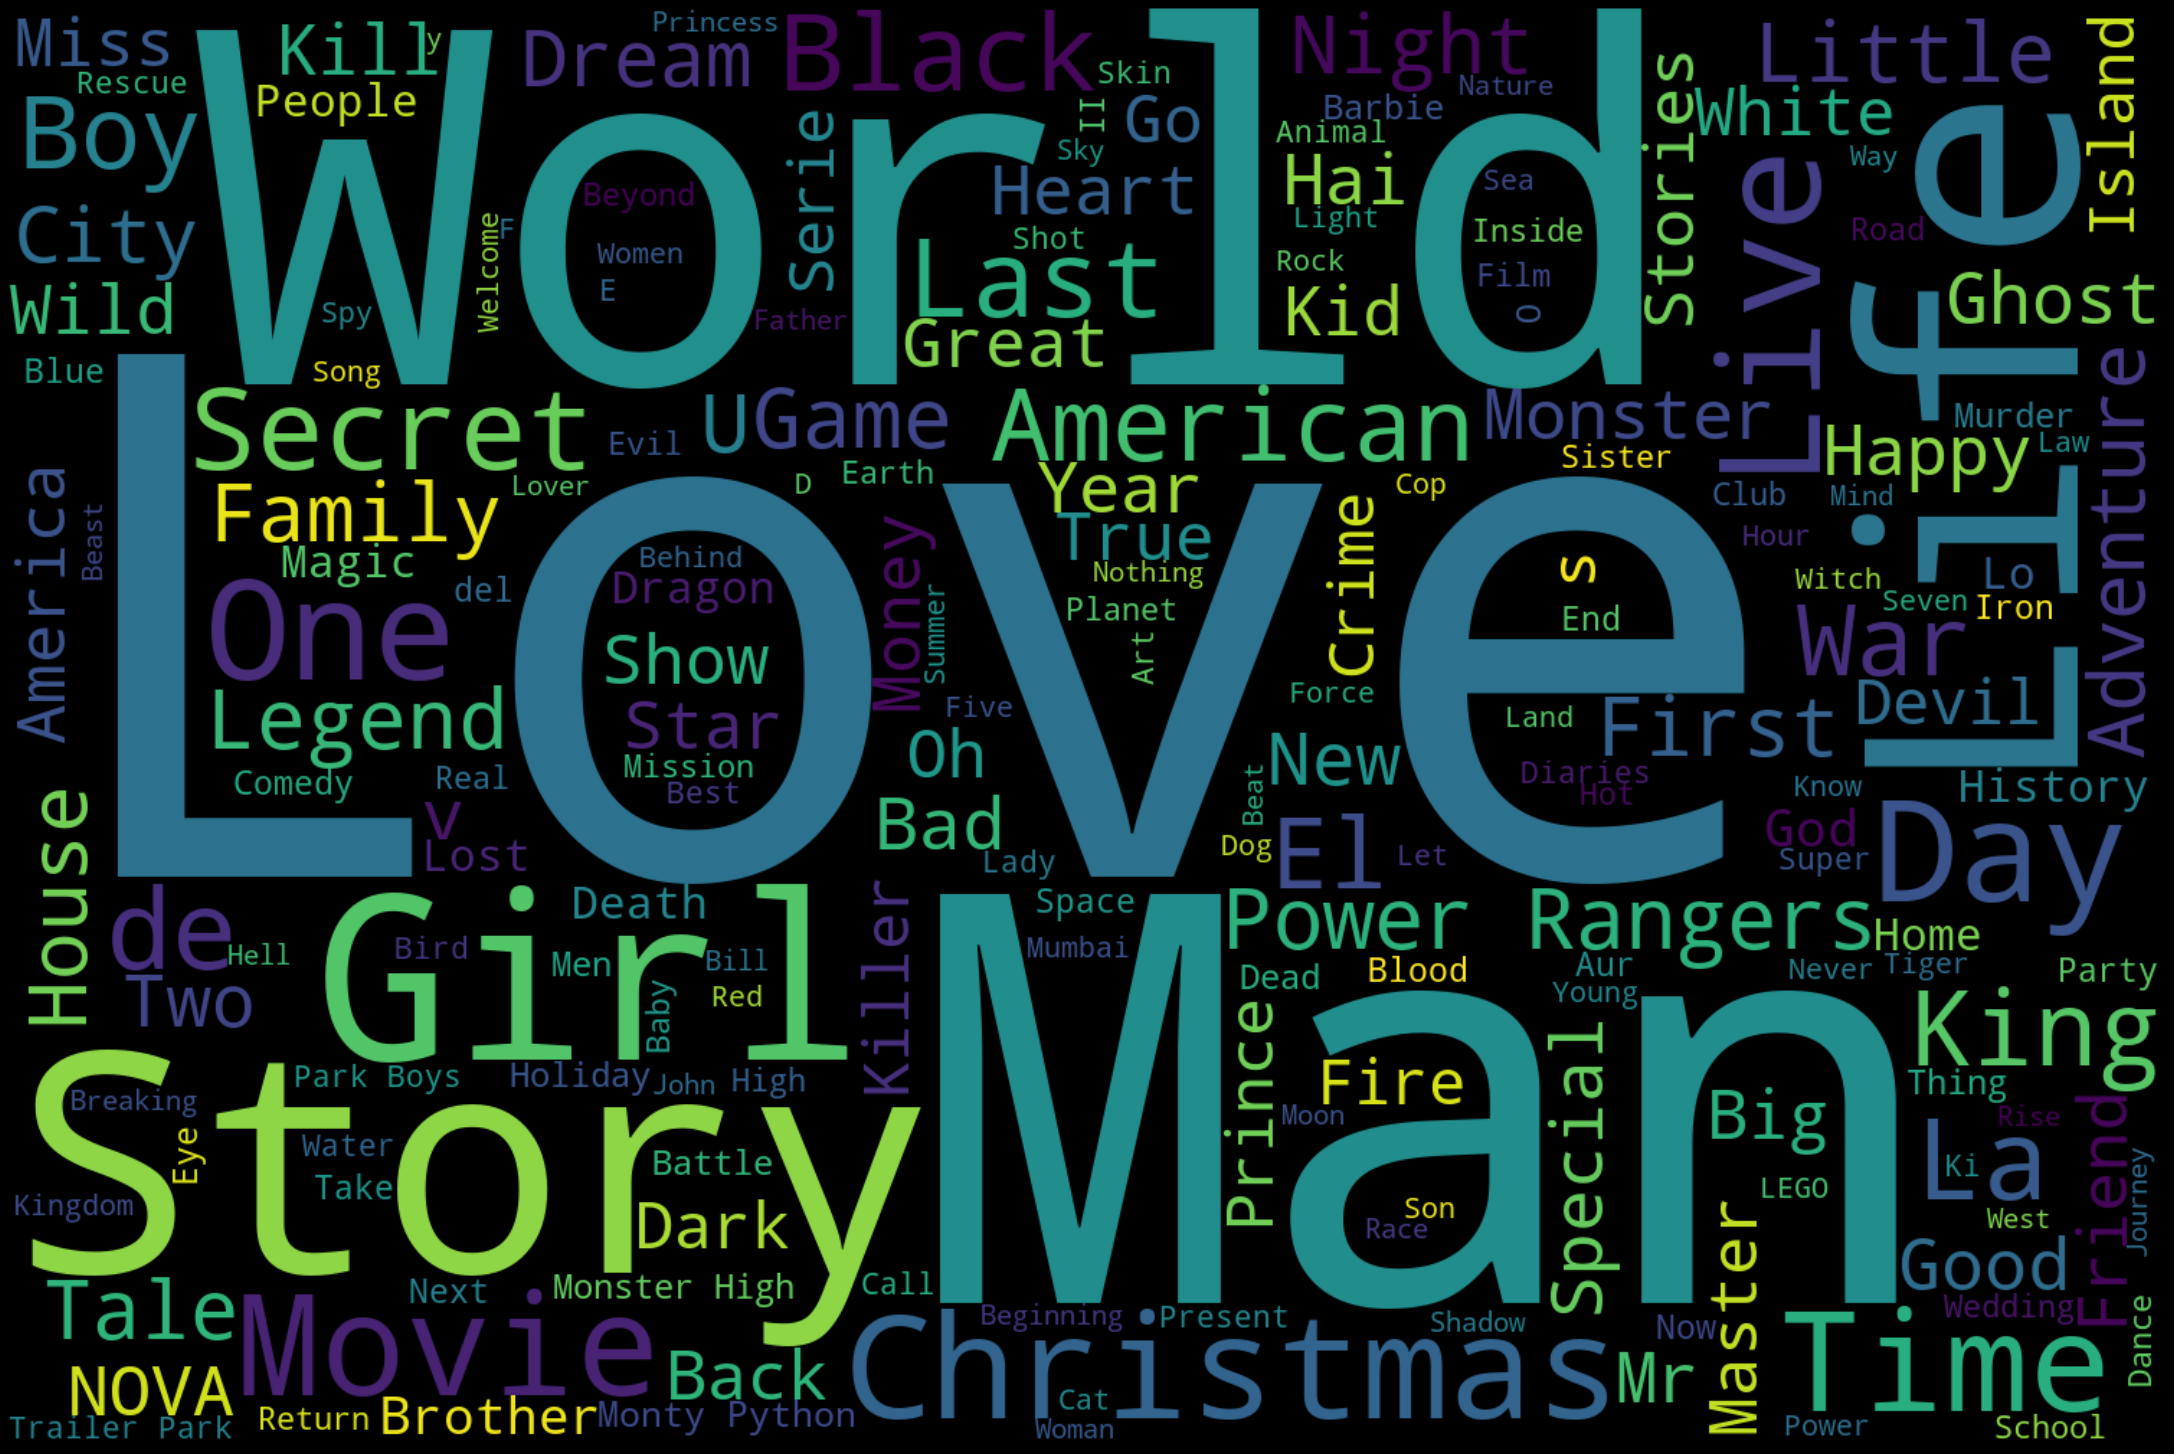

In [302]:
wordcloud = WordCloud(
    height = 1000,
    width = 1500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(' '.join(df['title'].values)))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Movies duration

Lastly, I'll study the duration of the american and foreign movies. First, I generate a box plot.


In [303]:
movies_duration = df[df['type'] == 'Movie'].filter(['american', 'duration'])
movies_duration['duration'] = movies_duration['duration'].map(lambda x: x.replace(' min', ''))
movies_duration['duration'] = pd.to_numeric(movies_duration['duration'])

fig = px.box(movies_duration, y="duration", color='american')
fig.show()


This tells us that,
in general, foreign movies are longer than american productions. Also, the american movies seem to be more concentrated around
the median than the foreign. We can further cement this insight by means of a violin plot.

In [304]:
fig = px.violin(movies_duration, y="duration", color="american", box=True, hover_data=movies_duration.columns)
fig.show()